In [1]:
library(spdep)
library(spatstat)
library(GISTools)
library(rgdal)
library(maptools)
library(RColorBrewer)
library(GWmodel)
library(e1071)

Warning message:
"package 'spdep' was built under R version 3.6.2"
Loading required package: sp

Loading required package: spData

Warning message:
"package 'spData' was built under R version 3.6.2"
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sf

Warning message:
"package 'sf' was built under R version 3.6.2"
Linking to GEOS 3.6.1, GDAL 2.2.3, PROJ 4.9.3

Warning message:
"package 'spatstat' was built under R version 3.6.2"
Loading required package: spatstat.data

Warning message:
"package 'spatstat.data' was built under R version 3.6.2"
Loading required package: nlme

Loading required package: rpart

Warning message:
"package 'rpart' was built under R version 3.6.2"

spatstat 1.62-2       (nickname: 'Shape-shifting lizard') 
For an introduction to spatstat, type 'beginner' 


Warning message:
"package 'GISTools' was built under R ver

In [2]:
# converts an unprojected shapefile into Albers equal area projection using NAD83 datum 
# with appropriate parallels and longitude of origin to minimize distortion

to_aea <- function(shp) {
    ct<-readOGR(shp)
    lat.range <- as.numeric(st_bbox(ct)$ymax) - as.numeric(st_bbox(ct)$ymin)
    lat1 <- as.numeric(st_bbox(ct)$ymin) + lat.range / 6
    lat2 <- as.numeric(st_bbox(ct)$ymax) - lat.range / 6
    lat0 <- (lat1 + lat2) / 2
    long.origin <- (as.numeric(st_bbox(ct)$xmin) + as.numeric(st_bbox(ct)$xmax)) / 2
    proj=sprintf("+proj=aea +lat_1=%f +lat_2=%f +lat_0=%f +lon_0=%f +x_0=0 +y_0=0 +datum=NAD83", lat1, lat2, lat0, long.origin)
    ct.aea<-spTransform(ct, proj)
    return(ct.aea)
}

In [3]:
# convert the data to Albers Equal Area
ct.aea <- to_aea("censustract.shp")

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\orms0027\Documents\day_of_data\censustract.shp", layer: "censustract"
with 732 features
It has 7 fields
Integer64 fields read as strings:  Sum_TOTPOP Sum_MINORI 


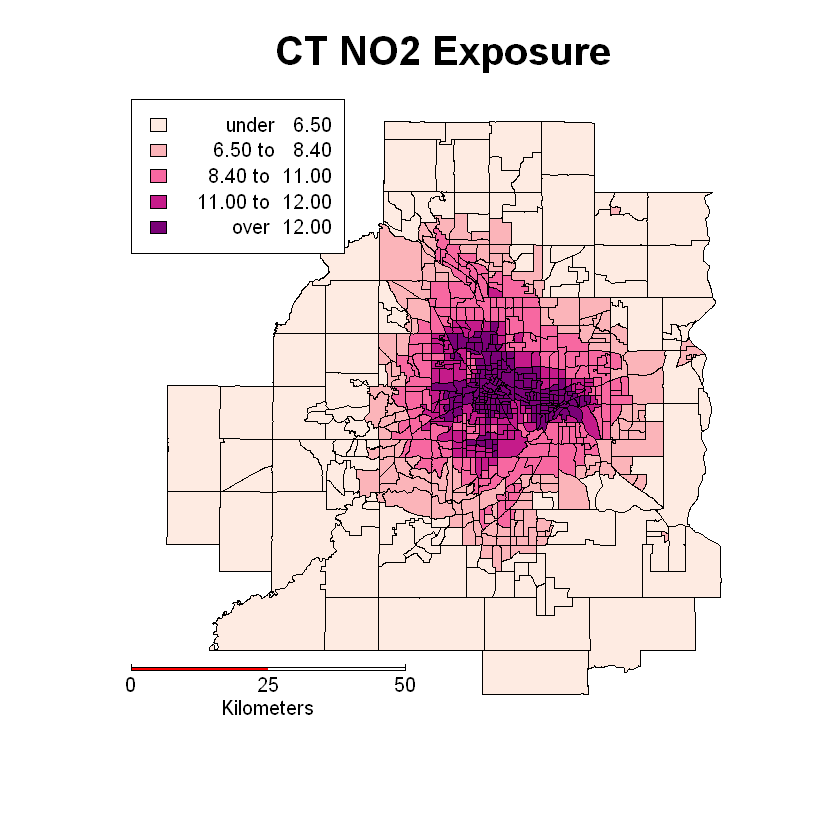

In [4]:
# make a choropleth map of NO2 exposure to visualize data
ctNO2 <- as.numeric(ct.aea$Avg_Avg_NO)
ctNO2.shade <- auto.shading(ctNO2,n=5,cols = brewer.pal(5,"RdPu"))
choropleth(ct.aea,ctNO2,shading=ctNO2.shade)
choro.legend(-57000,56500, ctNO2.shade,fmt="%6.2f")
title("CT NO2 Exposure",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

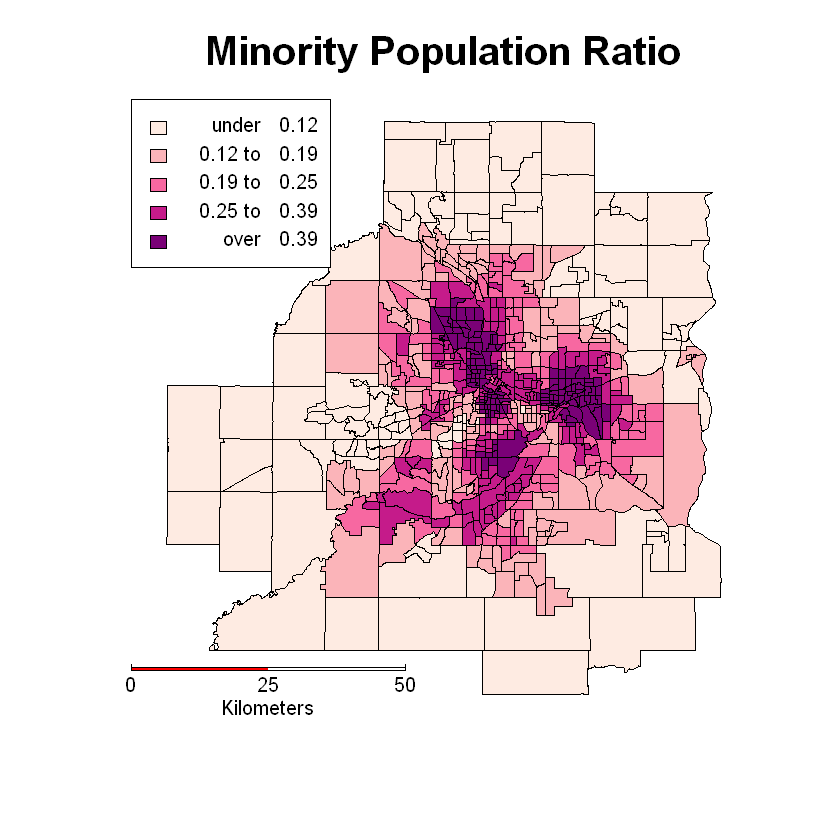

In [35]:
# make a choropleth map of minority population ratio to visualize data
minpop <- as.numeric(ct.aea$Pminori)
minpop.shade <- auto.shading(minpop,n=5,cols = brewer.pal(5,"RdPu"))
choropleth(ct.aea,minpop,shading=minpop.shade)
choro.legend(-57000,56500, minpop.shade,fmt="%6.2f")
title("Minority Population Ratio",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

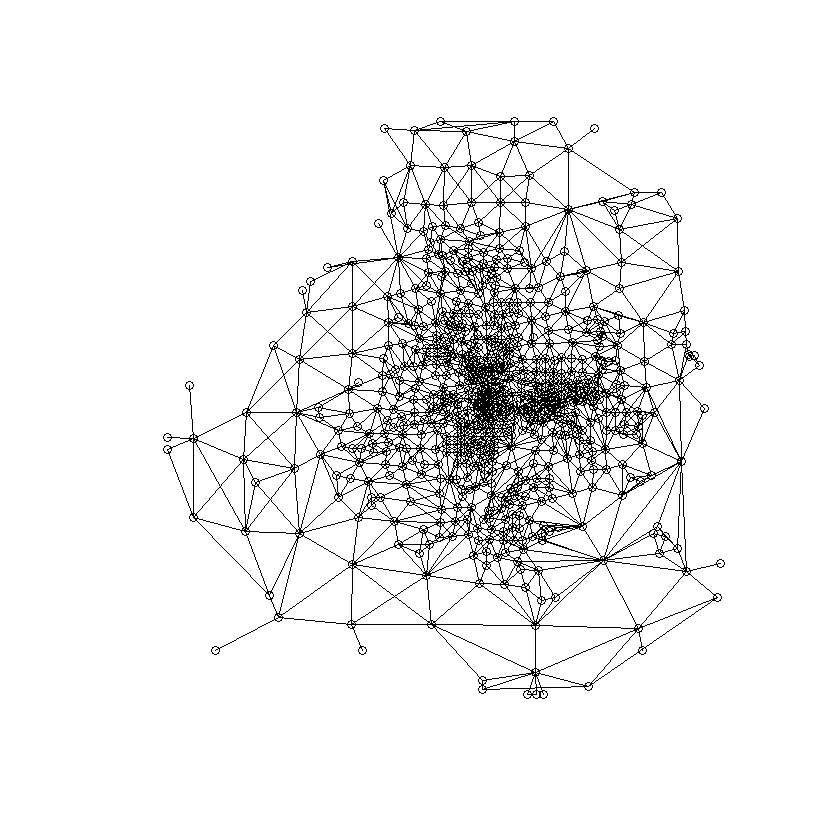

In [16]:
# convert spatial data to a contiguity graph to make it easy to tell which regions are neighbors
ct.nb<-poly2nb(ct.aea)

# visualize the contiguity graph
plot(ct.lw, coordinates(ct.aea))

In [17]:
# Calculating spatial autocorrelation requires constructing a row-standardized neighborhood weights matrix W
# for each row in W, all non-neighbors have a value of 0, while each neighbor has a value such that the row sum is 1
# (i.e. if a region has 2 neighbors, they will each have a value of 0.5)
ct.lw<- nb2listw(ct.nb)
ct.lw

Characteristics of weights list object:
Neighbour list object:
Number of regions: 732 
Number of nonzero links: 4548 
Percentage nonzero weights: 0.8487862 
Average number of links: 6.213115 

Weights style: W 
Weights constants summary:
    n     nn  S0       S1       S2
W 732 535824 732 254.8607 3036.543

In [6]:
# Calculate Local Moran's I.  This statistic is a measure of how similar a region is to neighboring regions.
# High local Moran's I values indicate a high degree of similarity 
# the localmoran() function will also calculate a p value of the statistic
ctNO2.mor <- localmoran(ctNO2,ct.lw)

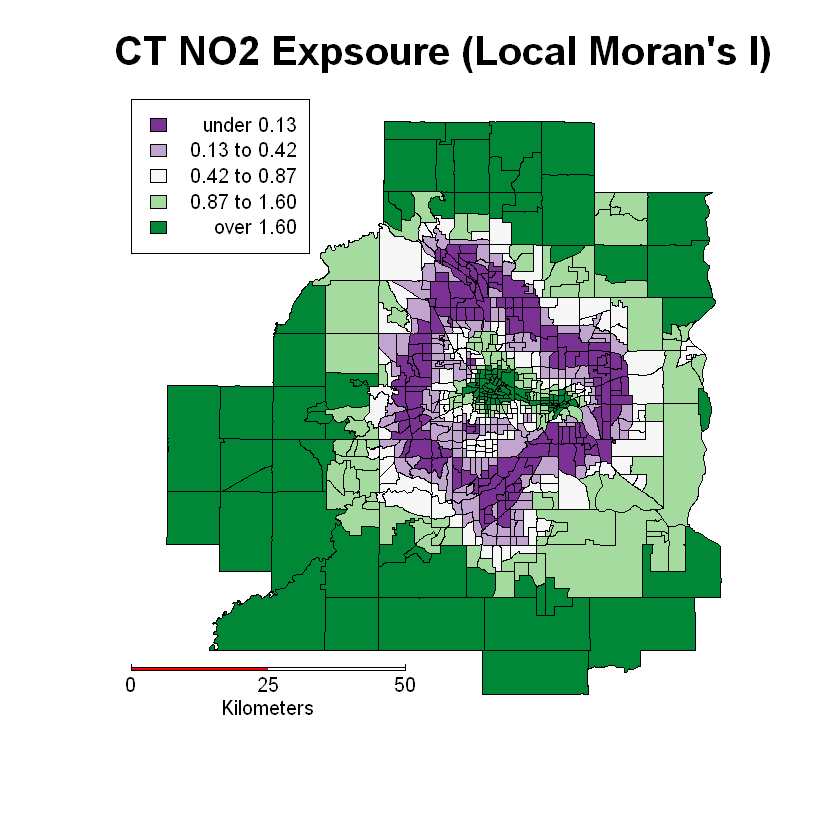

In [7]:
# Make a choropleth map of Moran's I values to see clusters of similar values
ctNO2.mor.Ii <- as.numeric(ctNO2.mor[,'Ii']) # the I statistic
ctNO2mor.shade <- auto.shading(ctNO2.mor.Ii, cols=brewer.pal(5,"PRGn"))
choropleth(ct.aea,ctNO2.mor[,1],shading=ctNO2mor.shade)
choro.legend(-57000,56500, ctNO2mor.shade,fmt="%1.2f")
title("CT NO2 Expsoure (Local Moran's I)",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

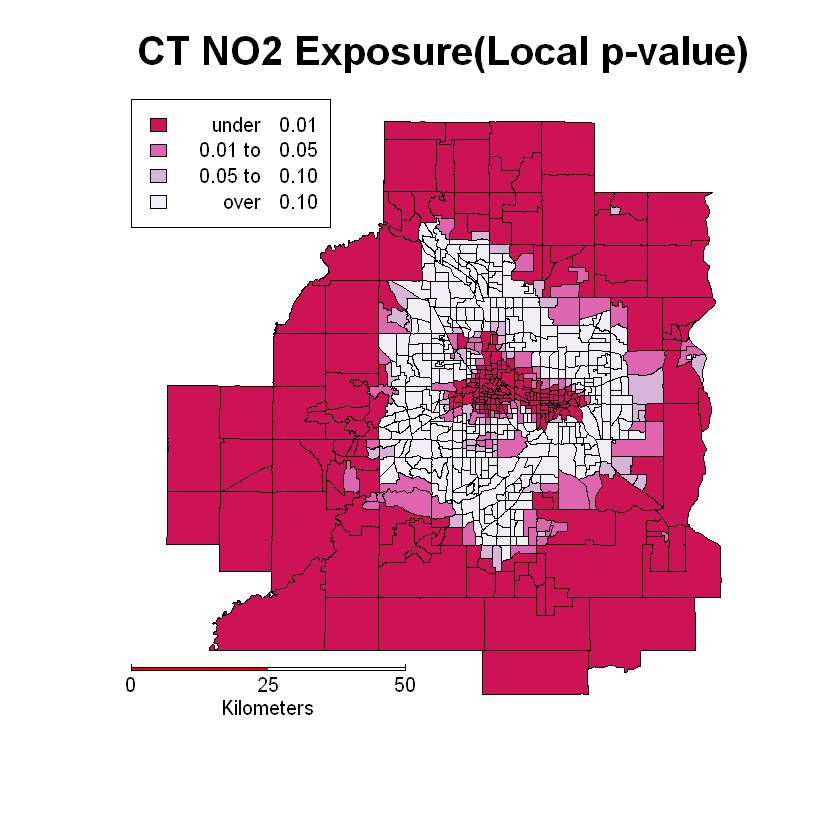

In [33]:
# Make a choropleth map of of p values to see where the statistically significant I values are located 

pvalNO2ct.shade <- shading(c(0.01,0.05,0.1),cols = rev(brewer.pal(4,'PuRd')))
choropleth(ct.aea,ctNO2.mor[,5],shading=pvalNO2ct.shade)
choro.legend(-57000,56500, pvalNO2ct.shade,fmt="%6.2f")
title("CT NO2 Exposure(Local p-value)", cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

In [9]:
summary(ct.aea)

Object of class SpatialPolygonsDataFrame
Coordinates:
        min      max
x -50571.41 50785.80
y -52412.68 52444.77
Is projected: TRUE 
proj4string :
[+proj=aea +lat_1=44.628422 +lat_2=45.257511 +lat_0=44.942967
+lon_0=-93.372210 +x_0=0 +y_0=0 +datum=NAD83 +ellps=GRS80
+towgs84=0,0,0]
Data attributes:
   Sum_TOTPOP    Sum_MINORI    Avg_MEDHIN       Sum_BA_HIG      Avg_Avg_NO    
 2997   :  4   132    :  4   Min.   : 18718   Min.   :  118   Min.   : 2.935  
 15212  :  3   1356   :  3   1st Qu.: 54536   1st Qu.: 2377   1st Qu.: 6.939  
 11260  :  2   2425   :  3   Median : 70152   Median : 3777   Median : 9.600  
 12237  :  2   3813   :  3   Mean   : 71116   Mean   : 4316   Mean   : 9.484  
 12330  :  2   1159   :  2   3rd Qu.: 87555   3rd Qu.: 5791   3rd Qu.:11.877  
 12386  :  2   1371   :  2   Max.   :138578   Max.   :19022   Max.   :18.964  
 (Other):717   (Other):715                                                    
      Pedu            Pminori      
 Min.   :0.05437   Min.   :0

In [14]:
ct.ols <- lm(Avg_Avg_NO~Pminori, data = ct.aea)
summary(ct.ols)


Call:
lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8050 -1.7311 -0.4376  1.5798  6.7407 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.4456     0.1486   43.38   <2e-16 ***
Pminori      11.2907     0.4531   24.92   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.298 on 730 degrees of freedom
Multiple R-squared:  0.4596,	Adjusted R-squared:  0.4589 
F-statistic: 620.8 on 1 and 730 DF,  p-value: < 2.2e-16


In [42]:
# to what degree are the OLS model residuals spatially autocorrelated?
moran.test(ct.aea$ct.ols.res,ct.lw)


	Moran I test under randomisation

data:  ct.aea$ct.ols.res  
weights: ct.lw    

Moran I statistic standard deviate = 39.982, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.867126471      -0.001367989       0.000471863 


In [50]:
# to what degree are the SAR model residuals spatially autocorrelated?
moran.test(ct.aea$ct.sar.res,ct.lw)


	Moran I test under randomisation

data:  ct.aea$ct.sar.res  
weights: ct.lw    

Moran I statistic standard deviate = 6.0724, p-value = 6.3e-10
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.1303905902     -0.0013679891      0.0004707993 


In [19]:
LM <- lm.LMtests(ct.ols, ct.lw, test="all")
LM


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)
weights: ct.lw

LMerr = 1580.8, df = 1, p-value < 2.2e-16


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)
weights: ct.lw

LMlag = 1687.9, df = 1, p-value < 2.2e-16


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)
weights: ct.lw

RLMerr = 8.012, df = 1, p-value = 0.004647


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)
weights: ct.lw

RLMlag = 115.09, df = 1, p-value < 2.2e-16


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)
weights: ct.lw

SARMA = 1695.9, df = 2, p-value < 2.2e-16



In [20]:
# spatial lag model
sar.ct <- lagsarlm(Avg_Avg_NO ~ Pminori, data = ct.aea, ct.lw)
summary(sar.ct)


Call:lagsarlm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea, listw = ct.lw)

Residuals:
      Min        1Q    Median        3Q       Max 
-1.793903 -0.250355  0.014838  0.274793  1.752686 

Type: lag 
Coefficients: (asymptotic standard errors) 
             Estimate Std. Error z value  Pr(>|z|)
(Intercept) -0.031478   0.041590 -0.7569    0.4491
Pminori      0.591216   0.102019  5.7952 6.825e-09

Rho: 0.9851, LR test value: 2211.7, p-value: < 2.22e-16
Asymptotic standard error: 0.0052171
    z-value: 188.82, p-value: < 2.22e-16
Wald statistic: 35654, p-value: < 2.22e-16

Log likelihood: -540.8903 for lag model
ML residual variance (sigma squared): 0.18868, (sigma: 0.43437)
Number of observations: 732 
Number of parameters estimated: 4 
AIC: 1089.8, (AIC for lm: 3299.5)
LM test for residual autocorrelation
test value: 44.614, p-value: 2.4001e-11


In [61]:
# Spatial Error Model
sem.ct <- errorsarlm(Avg_Avg_NO ~ Pminori, data = ct.aea, ct.lw)
summary(sem.ct)


Call:errorsarlm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea, listw = ct.lw)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.8216236 -0.2279397  0.0059161  0.2615933  1.9456041 

Type: error 
Coefficients: (asymptotic standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept)  5.35305    4.31719  1.2399     0.215
Pminori      2.35984    0.32261  7.3148 2.578e-13

Lambda: 0.99637, LR test value: 2228.3, p-value: < 2.22e-16
Asymptotic standard error: 0.0022018
    z-value: 452.52, p-value: < 2.22e-16
Wald statistic: 204770, p-value: < 2.22e-16

Log likelihood: -532.5931 for error model
ML residual variance (sigma squared): 0.18019, (sigma: 0.42449)
Number of observations: 732 
Number of parameters estimated: 4 
AIC: 1073.2, (AIC for lm: 3299.5)


In [62]:
ct.aea$ct.ols.res<-resid(ct.ols) #residuals ols

ct.aea$ct.sar.res<-resid(sar.ct) #residual sar

ct.aea$ct.sem.res<-resid(sem.ct) #residual sem

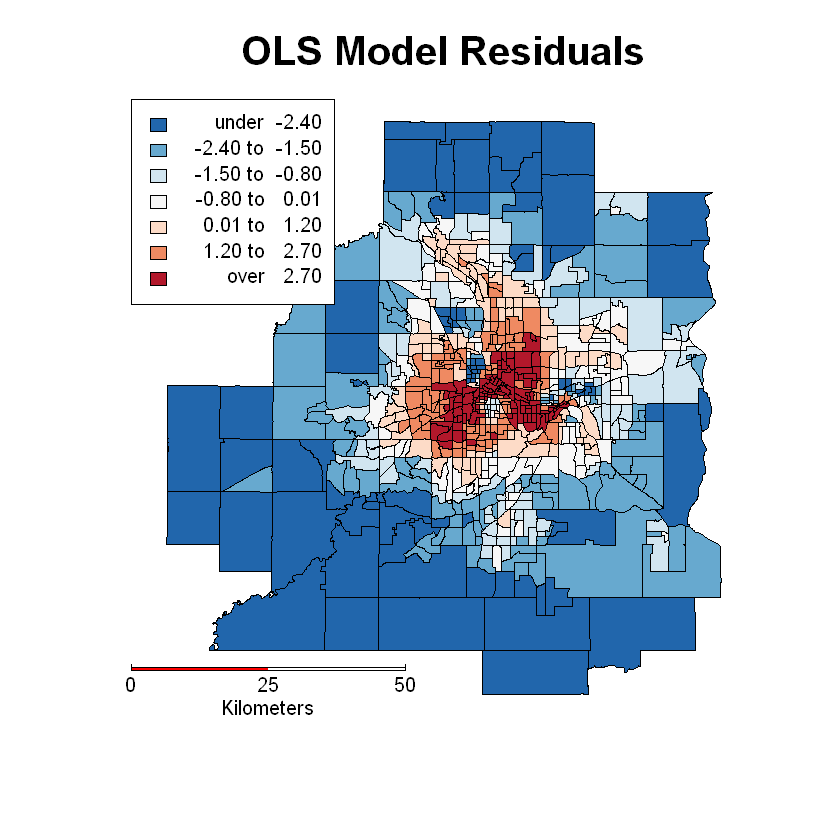

In [41]:
# make a choropleth map of the OLS model residuals to visualize data
olsres <- as.numeric(ct.aea$ct.ols.res)
olsres.shade <- auto.shading(olsres,n=7,cols = rev(brewer.pal(7,"RdBu")))
choropleth(ct.aea,olsres,shading=olsres.shade)
choro.legend(-57000,56500, olsres.shade,fmt="%6.2f")
title("OLS Model Residuals",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

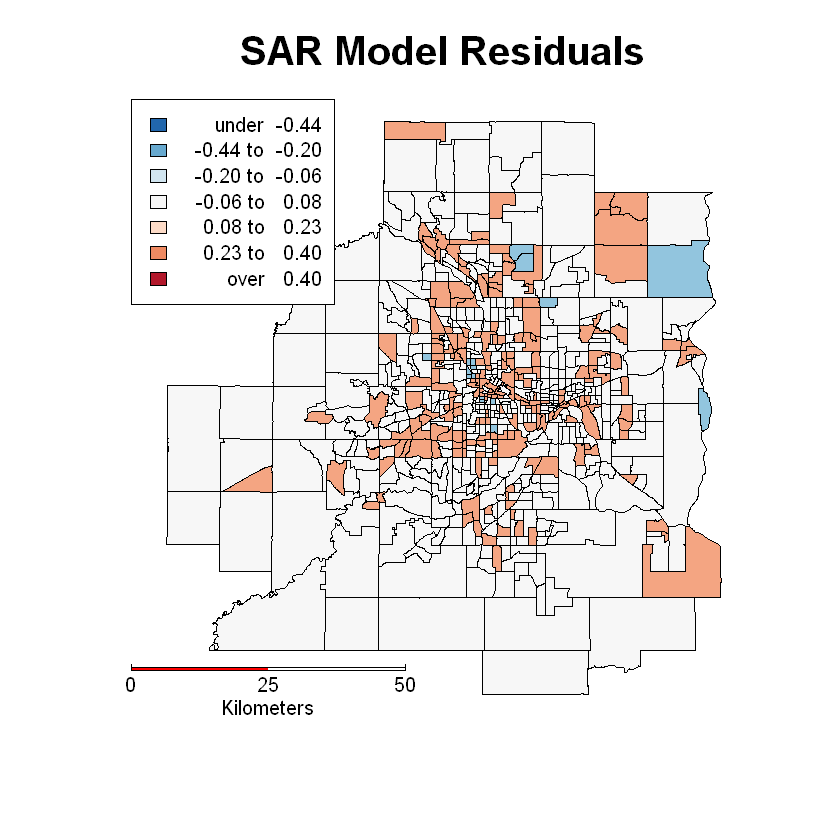

In [40]:
# make a choropleth map of the SAR model residuals to visualize data
sarres <- as.numeric(ct.aea$ct.sar.res)
sarres.shade <- auto.shading(sarres,n=7,cols = rev(brewer.pal(7,"RdBu")))
choropleth(ct.aea,sarres,shading=olsres.shade)
choro.legend(-57000,56500, sarres.shade,fmt="%6.2f")
title("SAR Model Residuals",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

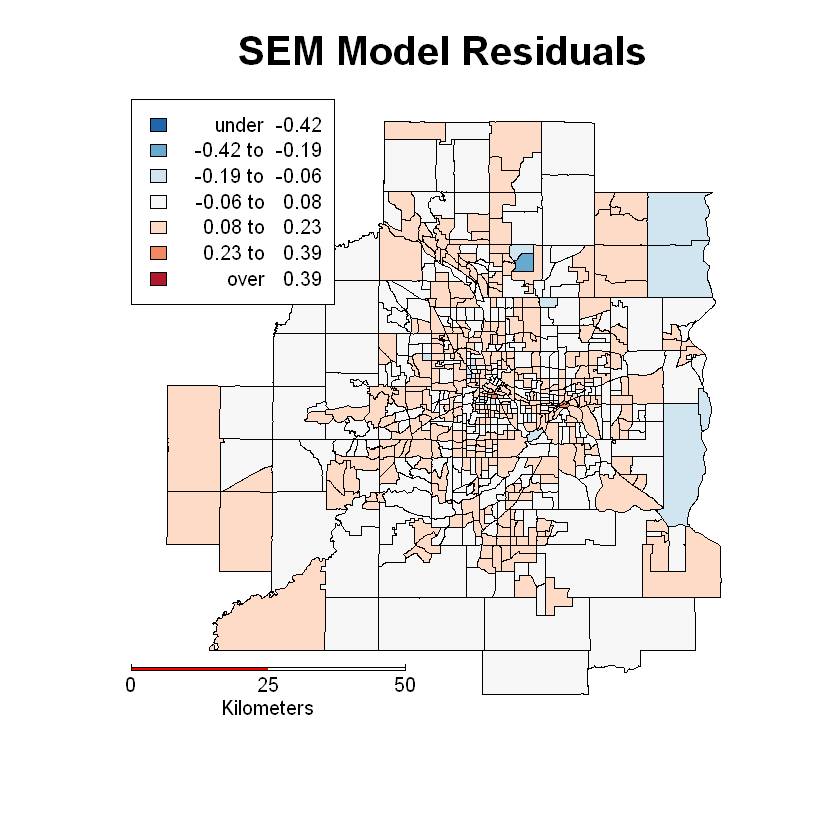

In [63]:
# make a choropleth map of the SAR model residuals to visualize data
semres <- as.numeric(ct.aea$ct.sem.res)
semres.shade <- auto.shading(semres,n=7,cols = rev(brewer.pal(7,"RdBu")))
choropleth(ct.aea,semres,shading=olsres.shade)
choro.legend(-57000,56500, semres.shade,fmt="%6.2f")
title("SEM Model Residuals",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

In [64]:
# to what degree are the SAR model residuals spatially autocorrelated?
moran.test(ct.aea$ct.sem.res,ct.lw)


	Moran I test under randomisation

data:  ct.aea$ct.sem.res  
weights: ct.lw    

Moran I statistic standard deviate = 6.2886, p-value = 1.601e-10
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.1350465353     -0.0013679891      0.0004705518 
